In [3]:
cd modules

[Errno 2] No such file or directory: 'modules'
/home/dadmaan/Documents/dev/py_music/instrument_classifier/modules


In [4]:
from instrument_classifier_m2_2 import ConvModel
from IPython.display import Audio

import helper
from helper import Metrics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from keras.callbacks import ModelCheckpoint

## Hyper-Parameters

In [5]:
# Valid dataset size 12678; Split ratio 80/10/10 percent
DS_TRAIN = 10144
DS_VALID = 1268
DS_TEST = 1268

EPOCHS = 20
BATCH_SIZE = 64
SHUFFLE_SIZE = 2 * BATCH_SIZE
STEPS_TRAIN = DS_TRAIN / BATCH_SIZE
STEPS_VALID = DS_VALID / BATCH_SIZE
STEPS_TEST = DS_TEST / BATCH_SIZE

## Data-set Prepration

In [6]:
train_ds = tfds.load(name='nsynth',
               split='valid[:80%]',
               download=False,
               try_gcs=True,
               data_dir='/home/dadmaan/Seagate Backup Plus Drive/datasets/nsynth')

valid_ds = tfds.load(name='nsynth',
               split='valid[80%:90%]',
               download=False,
               try_gcs=True,
               data_dir='/home/dadmaan/Seagate Backup Plus Drive/datasets/nsynth')

test_ds = tfds.load(name='nsynth',
               split='valid[90%:]',
               download=False,
               try_gcs=True,
               data_dir='/home/dadmaan/Seagate Backup Plus Drive/datasets/nsynth')

In [7]:
train_data = train_ds.map(lambda x: (x['audio'], x['instrument']['family']))
train_data = (train_data.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE).repeat())

valid_data = valid_ds.map(lambda x: (x['audio'], x['instrument']['family']))
valid_data = (valid_data.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE))

test_data = test_ds.map(lambda x: (x['audio'], x['instrument']['family']))
test_data = (test_data.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE))

train_data, valid_data, test_data

(<DatasetV1Adapter shapes: ((None, 64000), (None,)), types: (tf.float32, tf.int64)>,
 <DatasetV1Adapter shapes: ((None, 64000), (None,)), types: (tf.float32, tf.int64)>,
 <DatasetV1Adapter shapes: ((None, 64000), (None,)), types: (tf.float32, tf.int64)>)

## Model Prepration

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64000)]           0         
_________________________________________________________________
mel-spectrogram (MelSpectrog (None, 124, 128, 1)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 128, 1)       512       
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 126, 130, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 42, 43, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 42, 43, 32)        128       
_________________________________________________________________
block1_pool1 (MaxPooling2D)  (None, 41, 42, 32)        0     

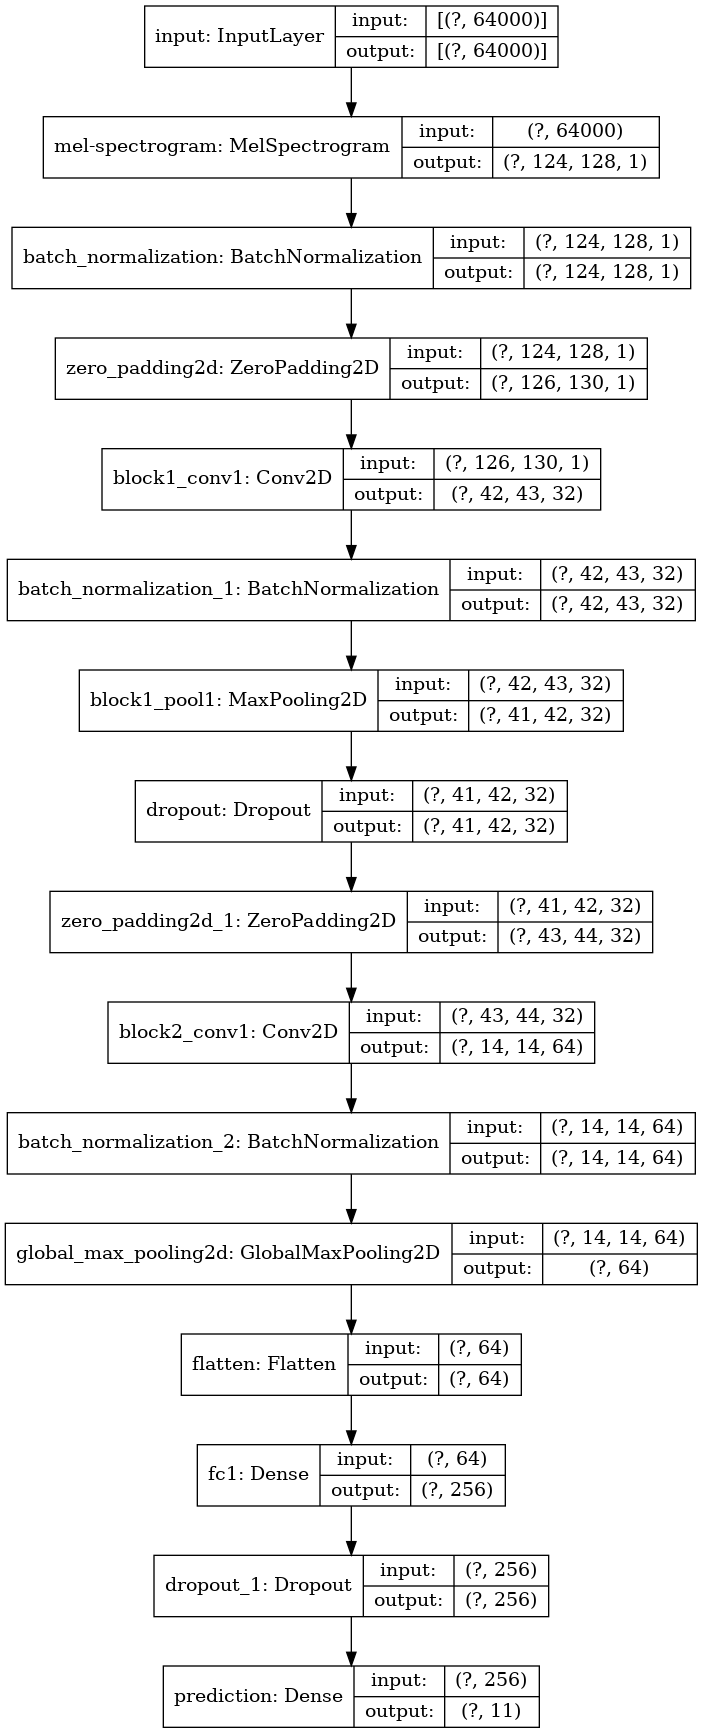

In [8]:
model = ConvModel()

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

model.summary()
tf.keras.utils.plot_model(model, to_file='../visualization/instrument_classifier_m2.png', 
                          show_shapes=True, 
                          show_layer_names=True)

## Load Weights

In [7]:
weights_path = '../weights/exp2_ic_weights.hdf5'
if os.path.exists(weights_path):
    model.load_weights(weights_path, by_name=False)
    print('Weights Loaded!')

## Train the Model

In [9]:
filepath = "../weights/exp2_ic_improvement_{epoch:02d}_{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

# tensorboard = tf.keras.callbacks.TensorBoard(
#     log_dir='../metrics/tensorboard/logs', histogram_freq=2, write_graph=True, write_images=True,
#     update_freq='epoch', profile_batch=2, embeddings_freq=0,
#     embeddings_metadata=None
# )

callbacks_list = [checkpoint]

In [10]:
history = model.fit(train_data, 
                    epochs=EPOCHS, 
                    steps_per_epoch=STEPS_TRAIN,
                    validation_data=valid_data,
                    validation_steps=STEPS_VALID,
                    callbacks=callbacks_list)

helper.save_training_history('../logs/exp2_tune_logs', history.history, plot=False)

Train for 158.5 steps, validate for 19.8125 steps
Epoch 1/20
159/158 [==============================] - 641s 4s/step - loss: 1.8211 - sparse_categorical_accuracy: 0.2498 - val_loss: 2.1092 - val_sparse_categorical_accuracy: 0.1932
Epoch 2/20
159/158 [==============================] - 467s 3s/step - loss: 1.0341 - sparse_categorical_accuracy: 0.5899 - val_loss: 1.5854 - val_sparse_categorical_accuracy: 0.6585
Epoch 3/20
159/158 [==============================] - 460s 3s/step - loss: 0.6888 - sparse_categorical_accuracy: 0.7346 - val_loss: 0.8533 - val_sparse_categorical_accuracy: 0.7815
Epoch 4/20
159/158 [==============================] - 483s 3s/step - loss: 0.5053 - sparse_categorical_accuracy: 0.8112 - val_loss: 0.4270 - val_sparse_categorical_accuracy: 0.8746
Epoch 5/20
159/158 [==============================] - 476s 3s/step - loss: 0.3794 - sparse_categorical_accuracy: 0.8607 - val_loss: 0.2785 - val_sparse_categorical_accuracy: 0.9101
Epoch 6/20
159/158 [=========================

## Save Weights

In [11]:
model.save_weights('../weights/exp2_tune_ic_weights.hdf5')

## Plot Training Results

## Evaluate the Model

In [12]:
results = model.evaluate(test_data, steps=STEPS_TEST)
evaluation = pd.DataFrame(results)
evaluation.to_csv('../logs/exp2_tune_evaluation_log.csv', index=False)

20/19 [==============================] - 56s 3s/step - loss: 0.0507 - sparse_categorical_accuracy: 0.9842
